# Композиции алгоритмов 

### Бэггинг

Для построения композиции при помощи бэггинга из $X$ случайно и независимо выбираются подвыборки $\tilde{X}_n, n = 1, \dots, N.$ После этого на каждой из этих выборок обучается алгоритм из параметрического множества $\mathcal{B},$ в результате чего получаем алгоритмы $b_n(x), n = 1, \dots, N.$ Прогноз итоговой композиции строится следующим образом: 

$$a(x) = \frac{1}{N} \sum_{n=1}^N b_n(x)$$ (в случае регрессии),

$$a(x) = \arg \max_{k = 1, \dots, K} \sum_{n=1}^N [b_n(x) = k]$$ (в случае классификации на K классов).

В случае бэггинга все базовые алгоритмы настраиваются на различные выборки из одного и того же распределения на $\mathbb{X} \times \mathbb{Y}$. При этом некоторые из них могут оказаться переобученными, однако усреднение позволяет ослабить этот эффект (объясняется тем, что для некоррелированных алгоритмов разброс композиции оказывается в $N$ раз меньше разброса отдельных алгоритмов, т.е. много деревьев с меньшей вероятностью настроятся на некоторый нетипичный объект по сравнению с одним деревом). Если $N$ достаточно велико, то последующие добавления новых алгоритмов уже не позволят улучшить качество модели.

### Бустинг

Пусть дана обучающая выборка $X = \{(x_i, y_i)\}_{i=1}^l$ и выбран функционал качества $Q(a, X) = \sum_{i=1}^l L(y_i, a(x_i)),$ который мы стремимся минимизировать. Градиентный бустинг строит композиции вида $a_N(x) = \sum_{n=0}^N \gamma_n b_n(x),$ где $b_n \in \mathcal{B}$ — базовые алгоритмы из некоторого параметрического семейства $\mathcal{B}$.

Композиция строится пошагово, на $n$-ом шаге к композиции добавляется алгоритм $b_n$ путём выполнения следующих действий:
 1. Вычисление сдвигов текущей композиции по выборке $X$: $$s_i^{(n)} = - \frac{\partial L}{\partial z} (y, z)\Bigg|_{z = a_{n-1}(x_i)}$$
 2. Обучение нового базового алгоритма на выборке $\{(x_i, s_i)\}_{i=1}^l$: $$b_n = \arg\min_{b \in \mathcal{B}} \sum_{i=1}^l (b_n(x_i) - s_i)^2$$
 3. Подбор коэффициента $\gamma_n$ при новом базовом алгоритме:
 $$\gamma_n = \arg \min_{\gamma} \sum_{i=1}^l L(y_i, a_{n-1}(x_i) + \gamma b_n(x_i))$$
 
При использовании градиентного бустинга можно понизить смещение моделей, но при этом разброс итоговой композиции останется таким же, как у отдельного базового алгоритма, или увеличится. Поэтому в качестве базовых алгоритмов удобно брать решающие деревья малой глубины, поскольку они обладают большим смещением и малым разбросом.

#### Модельный пример

Продемонстрируем сравнение двух методов на простом модельном примере.

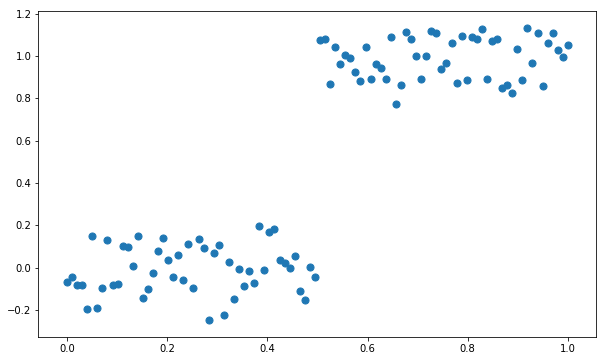

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.figure(figsize = (10, 6))
plt.scatter(X_train, Y_train, s=50)

Обучим на нем большое количество решающих деревьев бэггингом. Для наглядности на графиках используем неравномерный шаг по количеству деревьев.

C:\Users\Olga\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


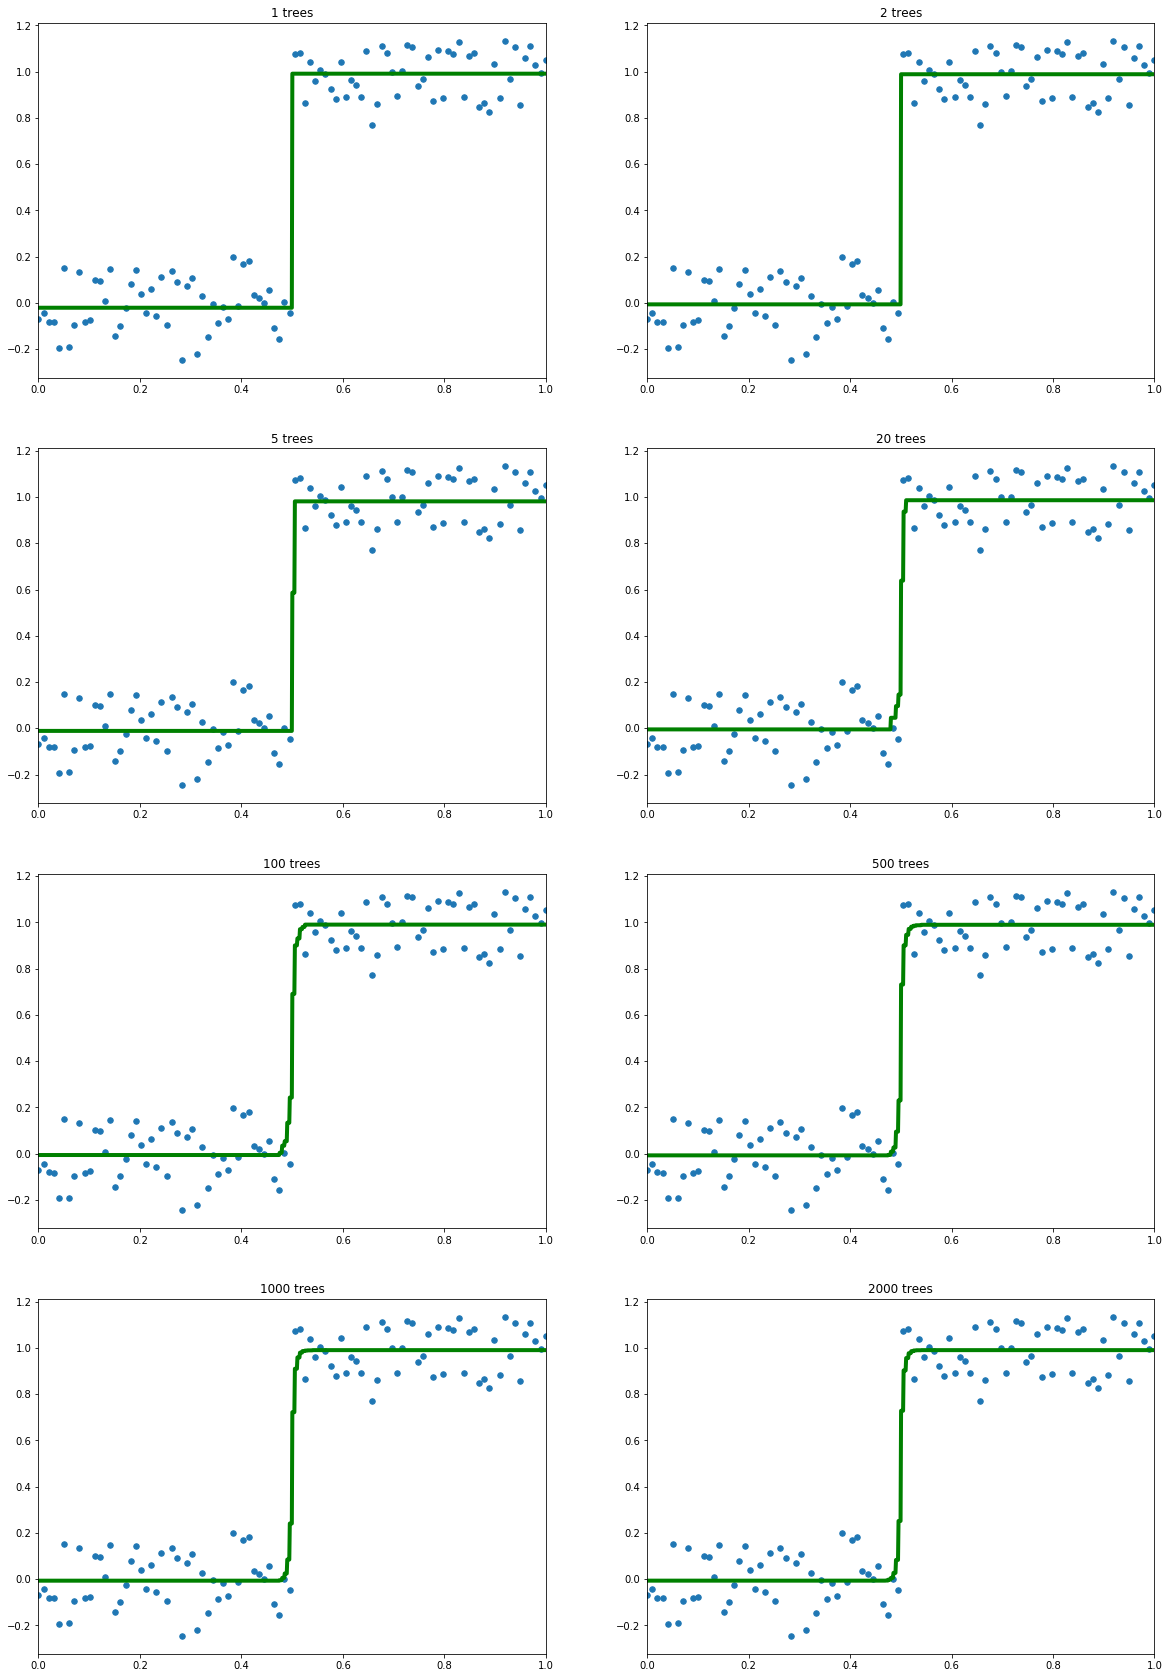

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

reg = BaggingRegressor(DecisionTreeRegressor(max_depth=1), warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Можно заметить, что с некоторого момента итоговая функция перестает меняться с ростом количества деревьев.

Теперь проделаем то же самое для градинентного бустинга.

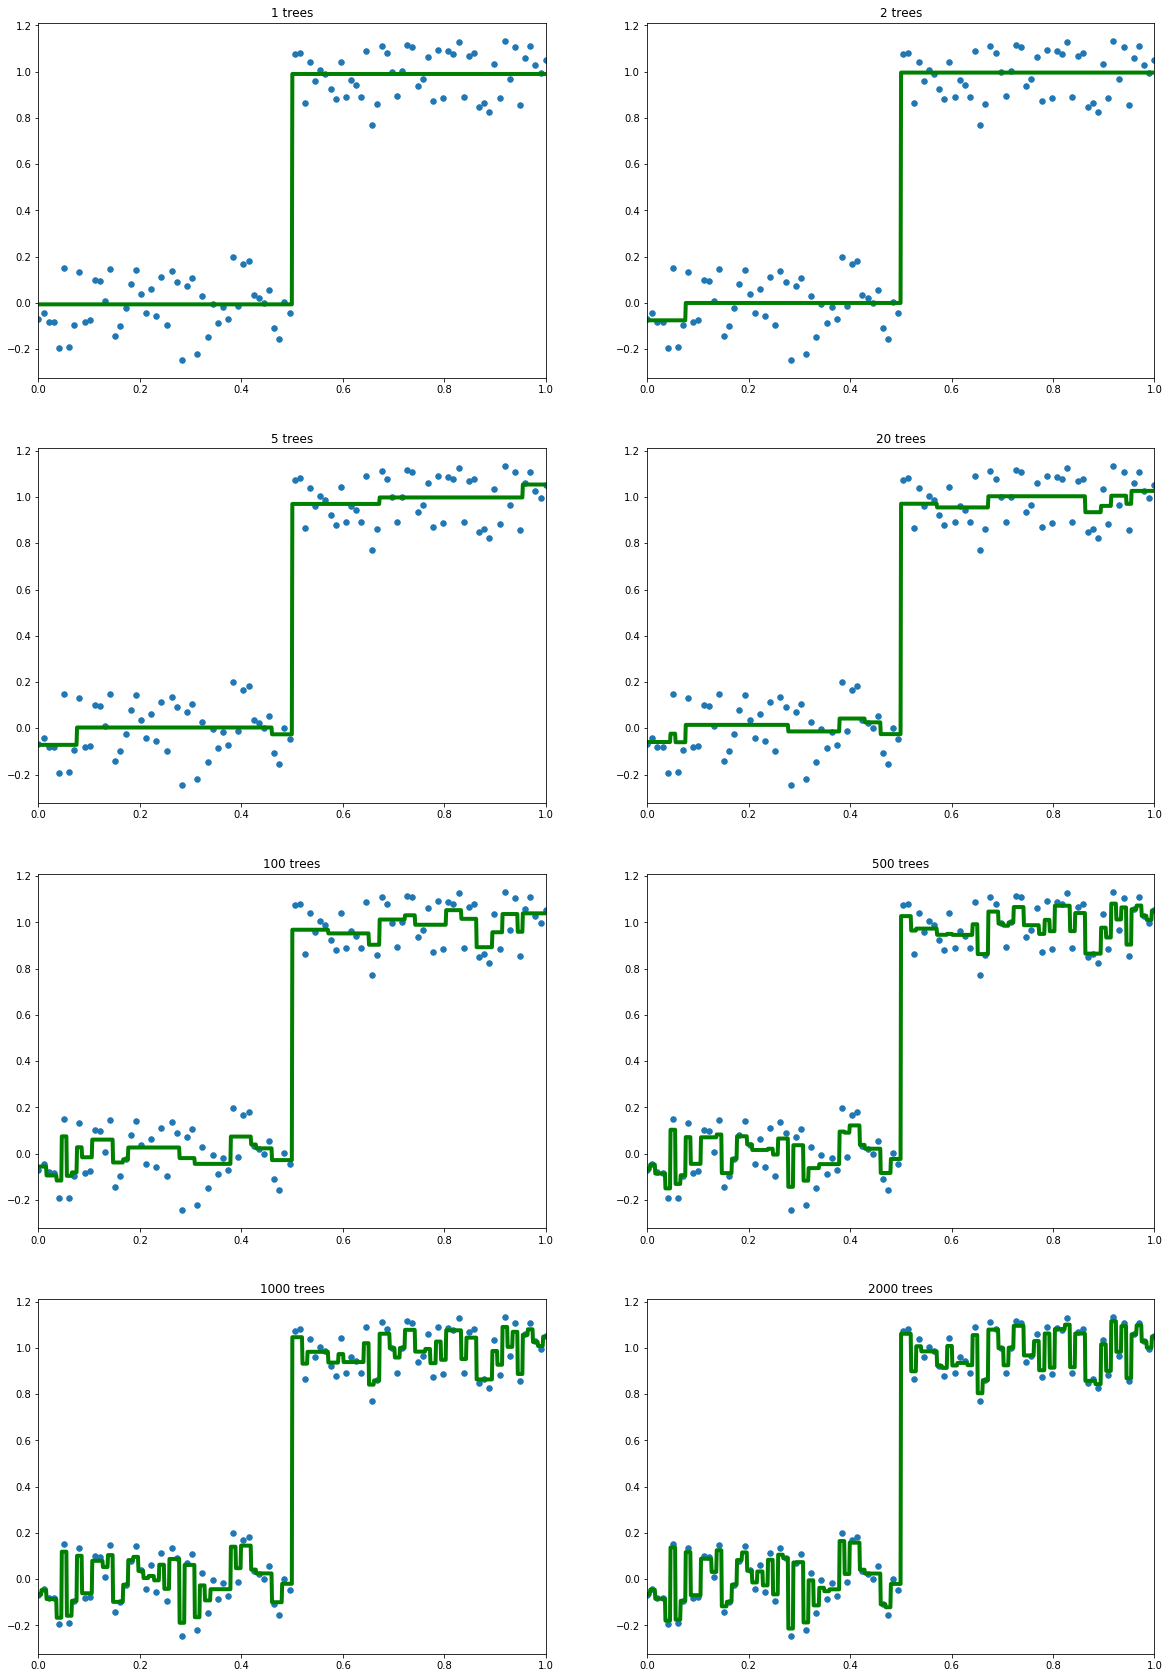

In [3]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Градиентный бустинг довольно быстро построил истинную зависимость, после чего начал настраиваться уже на конкретные объекты обучающей выборки, из-за чего сильно переобучился.

Бороться с этой проблемой можно с помощью выбора очень простого базового алгоритма или
же искусственным снижением веса новых алгоритмов при помощи шага $\eta$:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_N b_n(x).$$

Такая поправка замедляет обучение по сравнению с бэггингом, но зато позволяет получить менее переобученный алгоритм. Тем не менее, важно понимать, что переобучение всё равно будет иметь место при обучении сколь угодно большого количества базовых алгоритмов для фиксированного $\eta$.

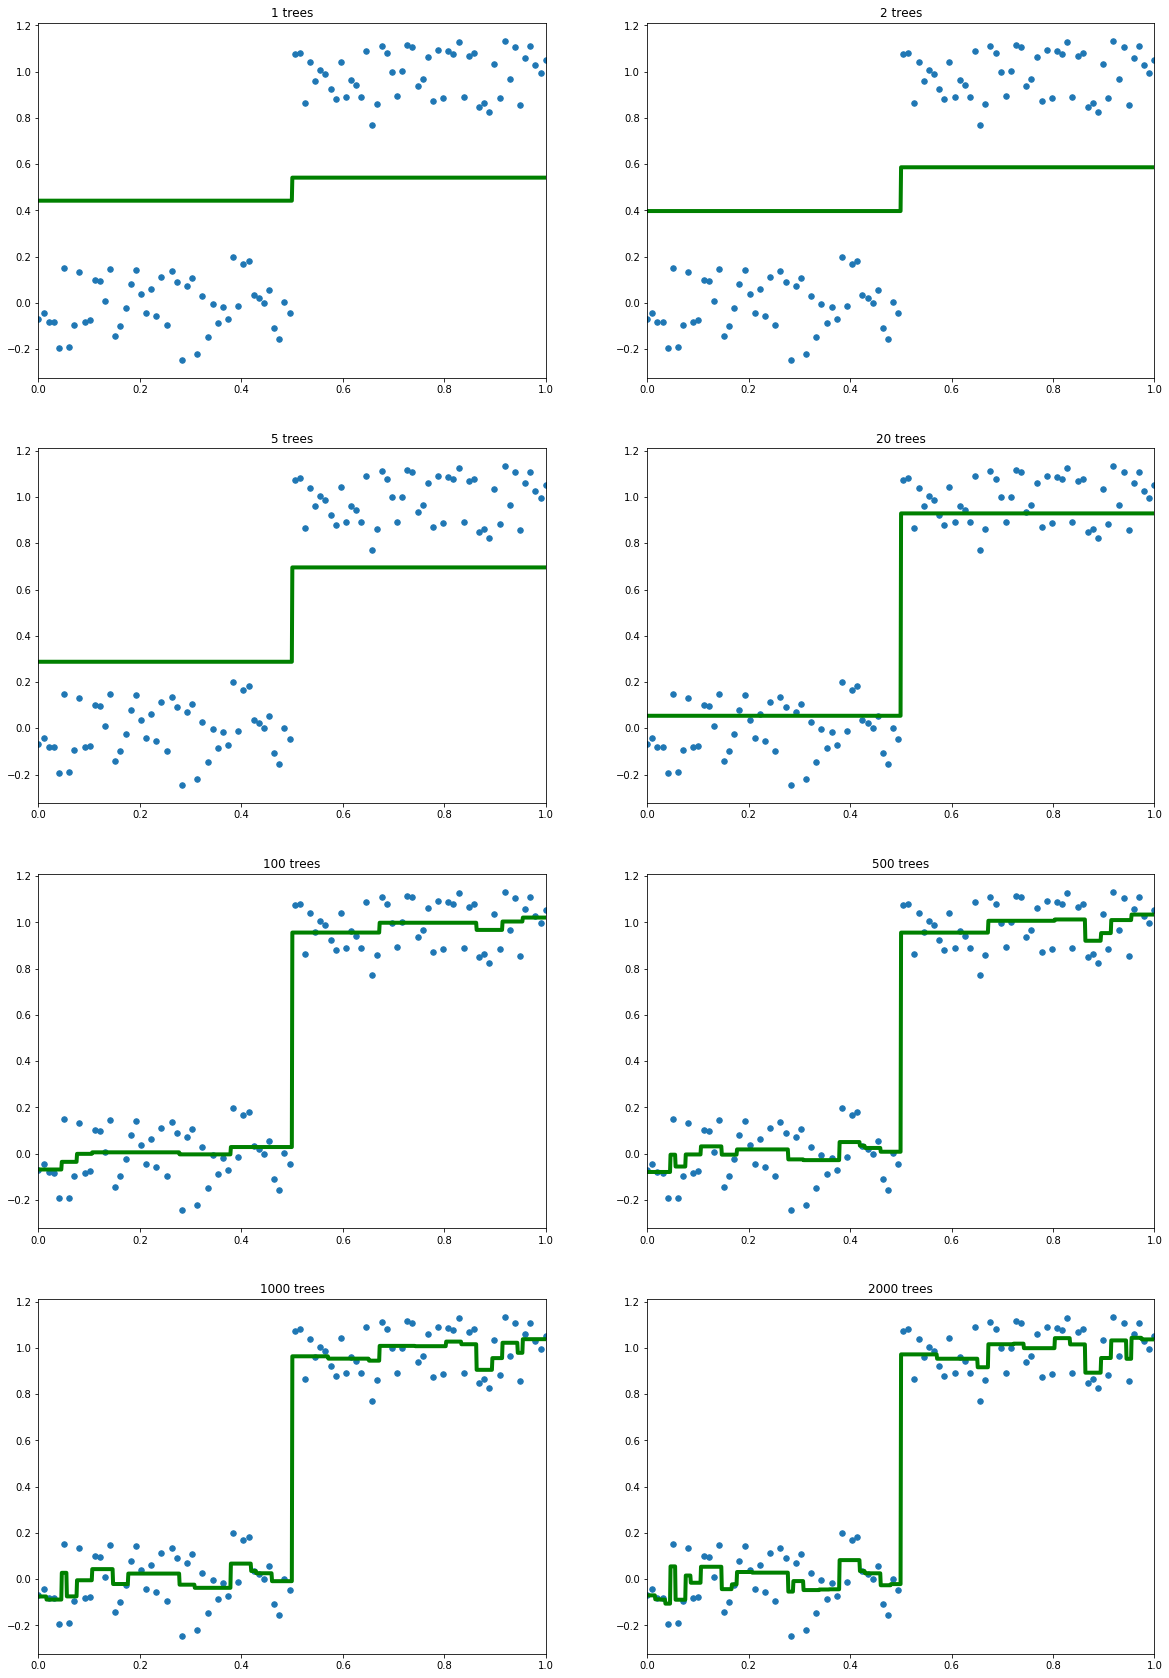

In [4]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

#### 1. Сравнение бэггинга и бустинга на реальных данных.
Будем работать с данными по диабету. 
* загрузите данные, разделите выборку на обучающую и тестовую в соотношении 7:3;
* постройте бэггинг и бустинг с парметрами по умолчанию, warm_start=True и числом деревьев n_estimators в диапазоне $\left[1,250\right]$;
* постройте зависимость ошибки на обучающей выборке и тестовой от числа используемых в композиции деревьев. 

In [5]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split

ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.3)

MAX_ESTIMATORS = 250

gbclf = GradientBoostingRegressor(warm_start=True)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_gb.append(1 - gbclf.score(X_train, Y_train))
    err_test_gb.append(1 - gbclf.score(X_test, Y_test))

gbclf = BaggingRegressor(warm_start=True)
err_train_bag = []
err_test_bag = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_bag.append(1 - gbclf.score(X_train, Y_train))
    err_test_bag.append(1 - gbclf.score(X_test, Y_test))

C:\Users\Olga\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Text(0.5,1,'Test')

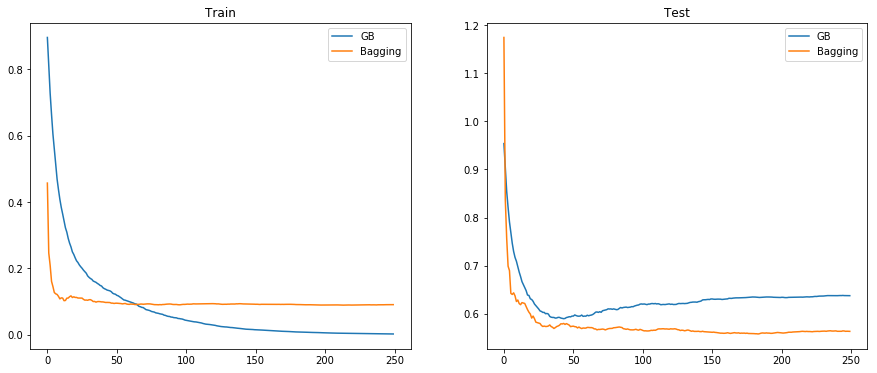

In [8]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='Bagging')
plt.legend()
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='Bagging')
plt.legend()
plt.title('Test')